In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('dataset.csv')
df = df[df['company'] == 'A']
df = df.drop(['Id', 'company'], axis=1) 
display(df.dtypes) 

gender                   object
age                       int64
nationality              object
sport                    object
ind-university_grade      int64
ind-debateclub             bool
ind-programming_exp        bool
ind-international_exp      bool
ind-entrepeneur_exp        bool
ind-languages             int64
ind-exact_study            bool
ind-degree               object
decision                   bool
dtype: object

The converts some boolean columns of the DataFrame to integer type. Then, it normalizes the age and university grade columns using the MinMaxScaler from Scikit-learn.

Finally, it performs one-hot encoding on some categorical columns of the DataFrame using the get_dummies() function from Pandas. The resulting DataFrame with one-hot encoded categorical columns is then displayed.

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

bool_cols = ['ind-debateclub', 'ind-programming_exp', 'ind-international_exp', 'ind-entrepeneur_exp', 'ind-exact_study', 'decision']
df[bool_cols] = df[bool_cols].astype(int)

scaler = MinMaxScaler()
df[['age', 'ind-university_grade']] = scaler.fit_transform(df[['age', 'ind-university_grade']])

cat_cols = ['gender', 'nationality', 'sport', 'ind-degree']
df = pd.get_dummies(df, columns=cat_cols)

print(df.head())

        age  ind-university_grade  ind-debateclub  ind-programming_exp  \
0  0.272727              0.766667               0                    0   
1  0.454545              0.666667               0                    1   
2  0.181818              0.666667               0                    1   
3  0.272727              0.766667               0                    1   
4  0.454545              0.400000               0                    0   

   ind-international_exp  ind-entrepeneur_exp  ind-languages  ind-exact_study  \
0                      0                    0              1                1   
1                      0                    0              2                1   
2                      1                    0              0                1   
3                      0                    0              1                1   
4                      0                    0              1                0   

   decision  gender_female  ...  sport_Cricket  sport_Football  spor

This code performs logistic regression on a dataset to predict whether a candidate will make a particular decision. It then uses SHAP values to interpret the model and gain insights into how each feature contributes to the model's decision-making.

Logistic regression is performed on the training data, and the accuracy of the logistic regression model is computed on the test set.

An explainer object is initialized using the SHAP library, and SHAP values are computed for the test set using this explainer object. These SHAP values are added as columns to a new DataFrame along with the original test set data. A bias score is computed for each candidate by summing up the SHAP values and adding the base value (intercept) of the model. A predicted decision column is added to the DataFrame with the predicted decision of the logistic regression model for each candidate. Finally, the resulting DataFrame is displayed, showing the first 5 rows of the data along with the SHAP values, bias scores, and predicted decisions.

In [3]:


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

X = df.drop(columns=["decision"])
y = df["decision"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression accuracy: {accuracy:.4f}")
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap_columns = [f"shap_{col}" for col in X_test.columns]
shap_df = pd.DataFrame(shap_values.values, columns=shap_columns)
df_with_shap = pd.concat([X_test.reset_index(drop=True), shap_df], axis=1)

df_with_shap['bias_score'] = shap_values.values.sum(axis=1) + shap_values.base_values

df_with_shap['predicted_decision'] = y_pred
print(df_with_shap.head())

Logistic Regression accuracy: 0.7050
        age  ind-university_grade  ind-debateclub  ind-programming_exp  \
0  0.636364              0.600000               0                    1   
1  0.818182              0.600000               0                    0   
2  0.272727              0.333333               0                    0   
3  0.000000              0.433333               0                    0   
4  0.454545              0.566667               0                    0   

   ind-international_exp  ind-entrepeneur_exp  ind-languages  ind-exact_study  \
0                      1                    0              0                1   
1                      0                    0              0                1   
2                      0                    0              2                0   
3                      0                    1              2                0   
4                      1                    0              1                0   

   gender_female  gender_male  

The code computes cosine similarities between candidates based on their feature values, and identifies pairs of candidates with very similar feature values but opposite predicted decisions.

It extracts the feature columns from the DataFrame and computes cosine similarities between all pairs of candidates using the cosine_similarity() function from Scikit-learn. A cosine similarity threshold is set to filter out pairs with low similarities.

The code then iterates through all pairs of candidates and checks if they have similar feature values but opposite predicted decisions. If so, the indices of the candidates are added to a list of pairs with different decisions.

Finally, the code displays the pairs of candidates with very similar feature values but opposite predicted decisions.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

feature_columns = df_with_shap.drop(columns=['bias_score', 'predicted_decision']).columns
similarities = cosine_similarity(df_with_shap[feature_columns])
cosine_similarity_threshold = 0.965
pairs_with_diff_decisions = []

n = len(df_with_shap)
for index1 in range(n):
    for index2 in range(index1 + 1, n):
        candidate1 = df_with_shap.iloc[index1]
        candidate2 = df_with_shap.iloc[index2]
        similarity = similarities[index1, index2]

        if similarity >= cosine_similarity_threshold and candidate1['predicted_decision'] != candidate2['predicted_decision']:
            pairs_with_diff_decisions.append((index1, index2))

print("Pairs of candidates with very similar features but opposite predicted decisions:")
for index1, index2 in pairs_with_diff_decisions:
    print(f"Candidate {index1} and Candidate {index2}")


Pairs of candidates with very similar features but opposite predicted decisions:
Candidate 78 and Candidate 157
Candidate 88 and Candidate 139
Candidate 102 and Candidate 139


Pair 1: Candidate 78 and Candidate 157


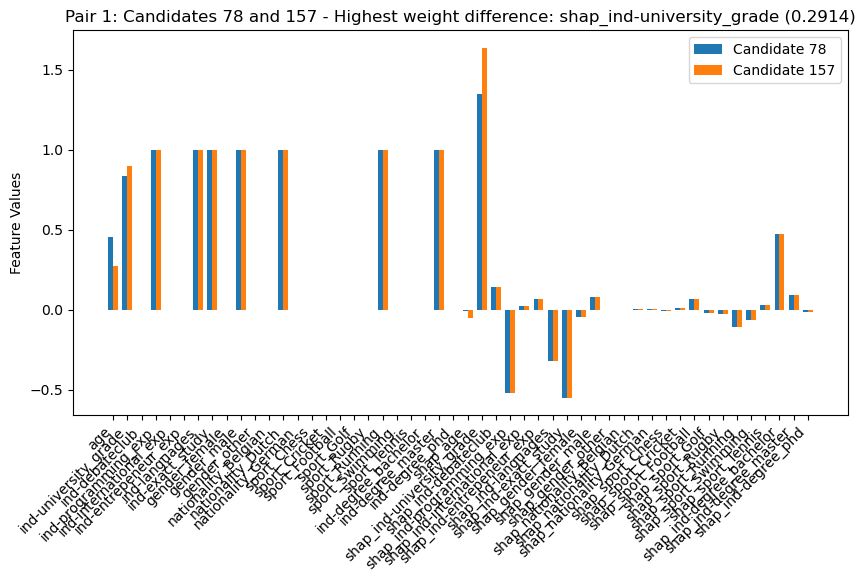

Pair 2: Candidate 88 and Candidate 139


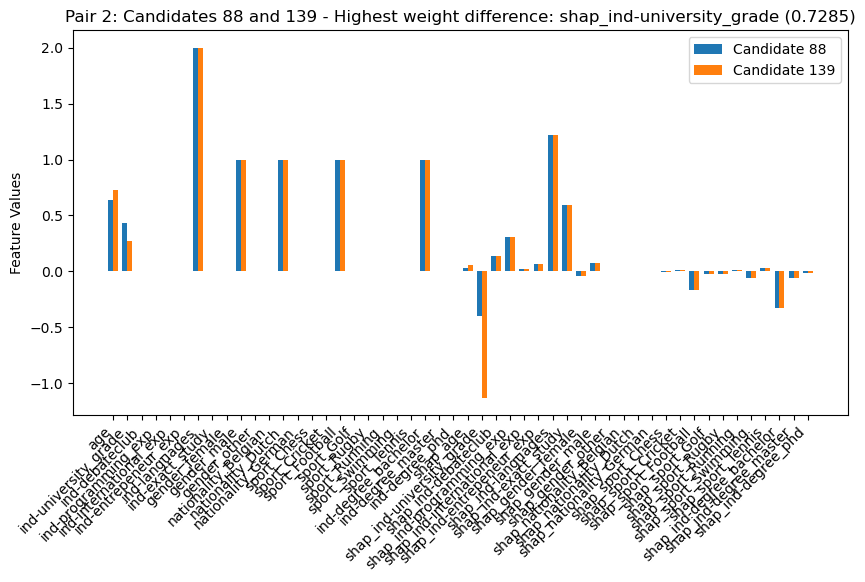

Pair 3: Candidate 102 and Candidate 139


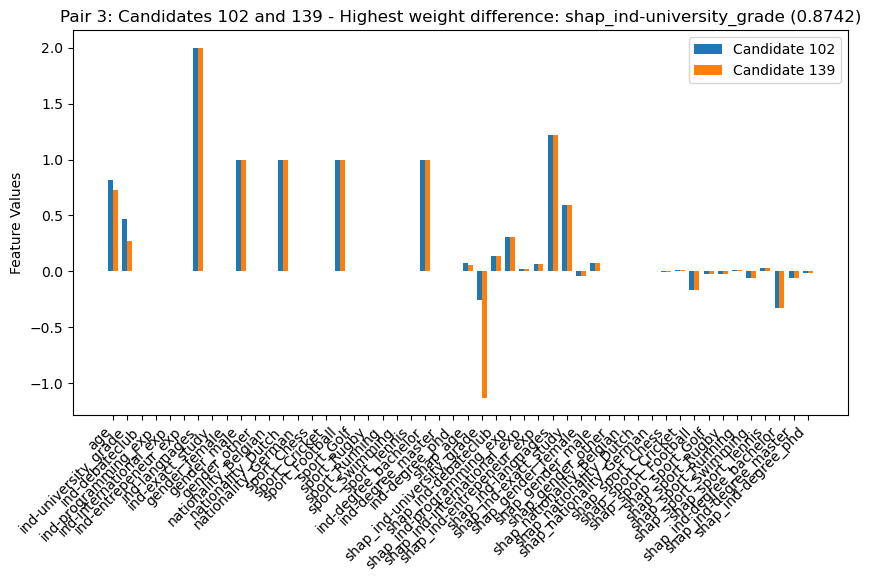

In [11]:
def plot_candidates(candidate1, candidate2, title, highest_diff_feature, highest_diff_value):
    fig, ax = plt.subplots(figsize=(10, 5))

    x = np.arange(len(candidate1))
    width = 0.35

    rects1 = ax.bar(x - width / 2, candidate1, width, label=f'Candidate {index1}')
    rects2 = ax.bar(x + width / 2, candidate2, width, label=f'Candidate {index2}')

    ax.set_ylabel('Feature Values')
    ax.set_title(f"{title} - Highest weight difference: {highest_diff_feature} ({highest_diff_value:.4f})")
    ax.set_xticks(x)
    ax.set_xticklabels(candidate1.index, rotation=45, ha='right')
    ax.legend()

    plt.show()

def find_highest_weight_difference(candidate1, candidate2):
    weight_diff = np.abs(candidate1 - candidate2)
    max_diff_index = weight_diff.idxmax()
    max_diff_value = weight_diff[max_diff_index]
    return max_diff_index, max_diff_value

for i, (index1, index2) in enumerate(pairs_with_diff_decisions, start=1):
    print(f"Pair {i}: Candidate {index1} and Candidate {index2}")
    candidate1 = df_with_shap.iloc[index1].drop(['predicted_decision', 'bias_score'])
    candidate2 = df_with_shap.iloc[index2].drop(['predicted_decision', 'bias_score'])

    max_diff_index, max_diff_value = find_highest_weight_difference(candidate1, candidate2)
    plot_candidates(candidate1, candidate2, f"Pair {i}: Candidates {index1} and {index2}", max_diff_index, max_diff_value)
